# Optimization of Neural Networks - Part 1

### Contents

1. What am I trying to do?
1. Batch Gradient Descent vs. Stochastic Gradient Descent vs. Mini-Batch Gradient Descent
1. Issues with Gradient Descent
  1. Diffculty in choosing the fixed learning rate
    1. Slow with low lr and can osciallte/diverge for high lr
  1. Learning rate remains constant through time
    1. Ideally we would like to start fast and slow down near the minima to avoid overshooting
  1. Learning rate remains same across parameters
    1. When signal for a particular parameters are sparse, we would like to make larger updates compared to parameters with frequest signal.
  1. Issues dealing with saddle points and pathological curvatures
1. Fixing Gradient Descent
  1. Second-order optimization methods: Newton's method
  1. RMSProp
  1. Momentum
  1. Nesterov's Accelerated Gradient
1. Realworld Optimizers
  1. SGD + Momentum
  1. AdaGrad
  1. AdaDelta
  1. Adam
  1. AdaMax
  1. AMSGrad
  1. AdamW
1. Which optimizer should I use?
1. Initialization of Neural Networks
  1. Why is initialization important?
  1. Zero initialization
  1. Unifrom
  1. Normal
  1. Kaiming
  1. Pretraining
1. Which initialization strategy should I use?

### How did I get here?

1. We have our data
1. We have finalized our initial neural network architecture to train
1. How will my neural network learn?
  1. Minimize the loss function with respect to the network parameters
  1. Calculus to rescue -> Iterative approach -> Gradient Descent

### Batch Gradient Descent vs. Stochastic Gradient Descent vs. Mini-batch Gradient Descent

<b>Batch Gradient Descent</b>
1. Batch gradient descent is guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces
2. Not online

<b>Stochastic Gradient Descent</b>
1. Batch gradient descent computes derivative with respect to all samples in training set. This computation can be very redundant in terms of new information a training sample provides
2. Online
3. Faster. Frequent updates but high variance. Large swings in parameter values
4. Convergence can become an issue but with appropriate learning rate scheduling, convergence behaviour is close to that of Bath Gradient Descent
5. Opportunity to jump to a better local minimas. Think exploration vs. exploitation

<b>Mini-batch Gradient Descent</b>
1. More stable convergence as parameters update variance reduces
2. Can be as fast as SGD due to parallelization
3. Searches through a larger part of the parameter space ( based on empirical data )

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

init = torch.tensor([-5.0,7.5])

class QuadFunc:
    '''
    Quadratic function
    '''
    
    def __init__(self,a,b,c,d,e):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
    
    def getParams(self,x,y):
        if y is None:
            y = x[1]
            x = x[0]
        
        return x, y
    
    def __call__(self,x,y=None):
        x,y = self.getParams(x,y)
        return 0.5*(self.a*x**2 + self.b*y**2 + 2*self.c*x*y) + self.d*x + self.e*y
    
    def grad(self,x,y=None):
        x,y = self.getParams(x,y)
        return torch.tensor([self.a*x+self.c*y+self.d,self.b*y+self.c*x+self.e])
    
    def hess(self,x,y=None):
        x,y = self.getParams(x,y)
        return torch.tensor([[self.a,self.c],[self.c,self.b]])

class GradientDescent:
    '''
    1st order optimizer with support for RMSProps and Momentum.
    '''
    
    def __init__(self,lr=1,b1=0.9,b2=0.999):
        self.lr = lr # learning rate
        self.b1 = b1 # grad aggregation param
        self.b2 = b2 # grad^2 aggregation param
        
        self.v = 0 # grad aggregation
        self.w = 0 # grad^2 aggregation
        self.t = 0
            
        self.eps = 1.0e-9
        
    def __call__(self,grad,hess):
        
        self.t += 1
        
        # aggregation
        self.v = self.b1*(self.v) + (1-self.b1)*grad
        self.w = self.b2*(self.w) + (1-self.b2)*grad**2
        
        # bias correction
        vcorr = self.v/(1-self.b1**self.t)
        wcorr = self.w/(1-self.b2**self.t) if self.b2 != 0 else 1
        
        return -self.lr*vcorr/( wcorr**0.5 + self.eps )
        
    
class Newtons:
    '''
    2nd order optimization
    '''
    
    def __init__(self,lr=1):
        self.lr = lr
    
    def __call__(self,grad,hess):
        return -self.lr*torch.matmul(torch.inverse(hess),grad)
        

class NAG:
    
    def __init__(self,lr=1,gamma=0.9):
        self.lr = lr
        self.gamma = gamma
        self.m = 0
        
    def __call__(self,grad,hess):
        # Grad and Hess passed here are based on future location based on prior momentum
        
        self.m = self.gamma * self.m + grad
        return -self.lr*self.m

class NAG2:
    
    def __init__(self,lr=1,gamma=0.9):
        self.lr = lr
        self.gamma = gamma
        self.m = 0
        
    def __call__(self,grad,hess):
        # Dozat's implementation
        
        self.m = self.gamma * self.m + grad
        return -self.lr*(grad+self.gamma*self.m)
    
def runOptim(init,optim,func,steps,nag=False):
    
    curpos = init
    path = [curpos]
    val = [func(curpos)]
    
    for _ in range(steps):
        
        if nag:
            grad = func.grad(curpos-optim.lr*optim.gamma*optim.m)
            hess = func.hess(curpos-optim.lr*optim.gamma*optim.m)            
        else:
            grad = func.grad(curpos)
            hess = func.hess(curpos)
            
        dx = optim(grad,hess)
        curpos = curpos + dx
        path.append(curpos)
        val.append(func(curpos))
    
    return path, val

def showPath(func,init,paths,labels,colors,title):

    x = torch.arange(-10,10,0.05)
    y = torch.arange(-10,10,0.05)
    
    # create meshgrid
    xx, yy = torch.meshgrid(x,y)
    zz = func(xx,yy)
    
    # create contour
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    cp = ax.contourf(xx,yy,zz)
    fig.colorbar(cp)
    
    # mark initial point
    ax.plot(init[0],init[1],'ro')
    ax.text(init[0]+0.5,init[1]+0.5,'Intial Point',color='white')
    
    # Plot paths
    for pnum in range(len(paths)):
        for i in range(len(paths[pnum])-1):
            curpos = paths[pnum][i]
            d = paths[pnum][i+1] - curpos
            ax.arrow(curpos[0],curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
            ax.text(curpos[0]+d[0],curpos[1]+d[1],str(i),color='white')
    
    # Add legend
    legends = []
    for col in colors:
        legends.append(mpatches.Patch(color=col))
    ax.legend(legends,labels)
    
    # Add title
    ax.set_title(title)

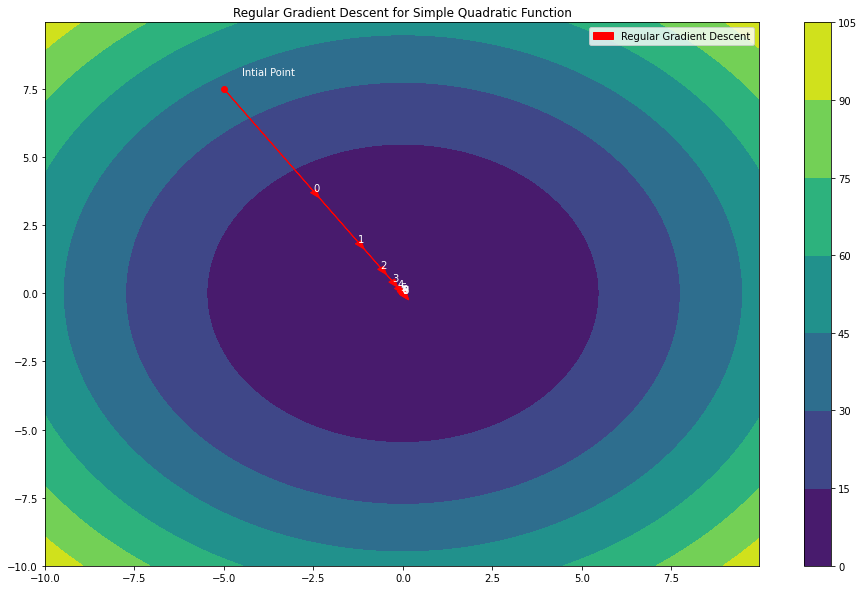

In [3]:
# How regular gradient descent works

init = torch.tensor([-5.0,7.5])
simple = QuadFunc(1,1,0,0,0)
steps = 10
regGD = GradientDescent(0.5,0,0)
path, _ = runOptim(init,regGD,simple,steps)
showPath(simple,init,[path],['Regular Gradient Descent'],['r'],'Regular Gradient Descent for Simple Quadratic Function')

### Issues wih Gradient Descent

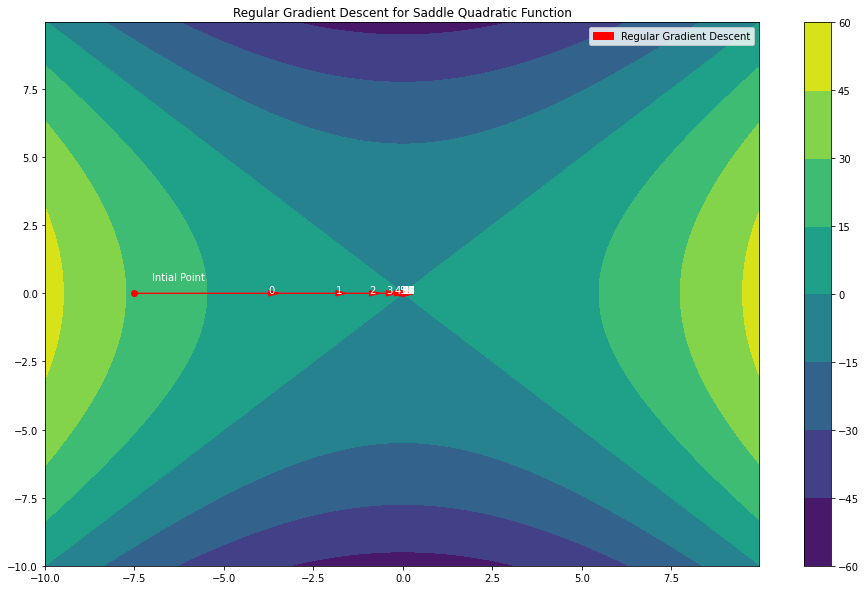

In [4]:
# Saddle Points
# Highly non-convex loss surfaces in DL are peppered with saddle points which make progress hard

saddle = QuadFunc(1,-1,0,0,0)
init = torch.tensor([-7.5,0.0])
steps = 20
regGD = GradientDescent(0.5,0,0)
func = saddle

path, _ = runOptim(init,regGD,func,steps)
showPath(func,init,[path],['Regular Gradient Descent'],['r'],'Regular Gradient Descent for Saddle Quadratic Function')

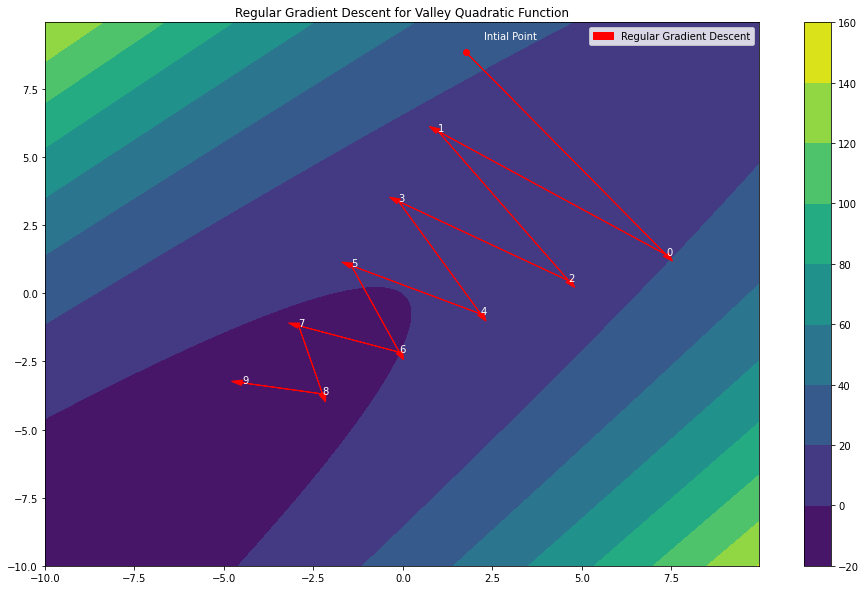

In [5]:
# Pathological Curvature or Valleys
# Severly limits the learning rate that can be used to make faster progress and also explore larger area
# Also creates issues in terms of speed of convergence

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
patho = QuadFunc(a,a,-a,a,a)

#init = torch.tensor([-5.0,7.5])
#patho = QuadFunc(1,0,0,0,1)
steps = 10
regGD = GradientDescent(1.3,0,0)
func = patho

path, _ = runOptim(init,regGD,func,steps)
showPath(func,init,[path],['Regular Gradient Descent'],['r'],'Regular Gradient Descent for Valley Quadratic Function')

### Fixing Gradient Descent

#### Newton's Method

$\theta_{t+1} = \theta_{t} - \eta*H_{t}^{-1}*g_{t}$



$\theta_{t}$ is the parameter at time-step $t$<br>
$\eta$ is the learning rate<br>
$H_{t}^{-1}$ is the inverse Hessian at time-step $t$<br>
$g_{t}$ is the gradient at time-step $t$

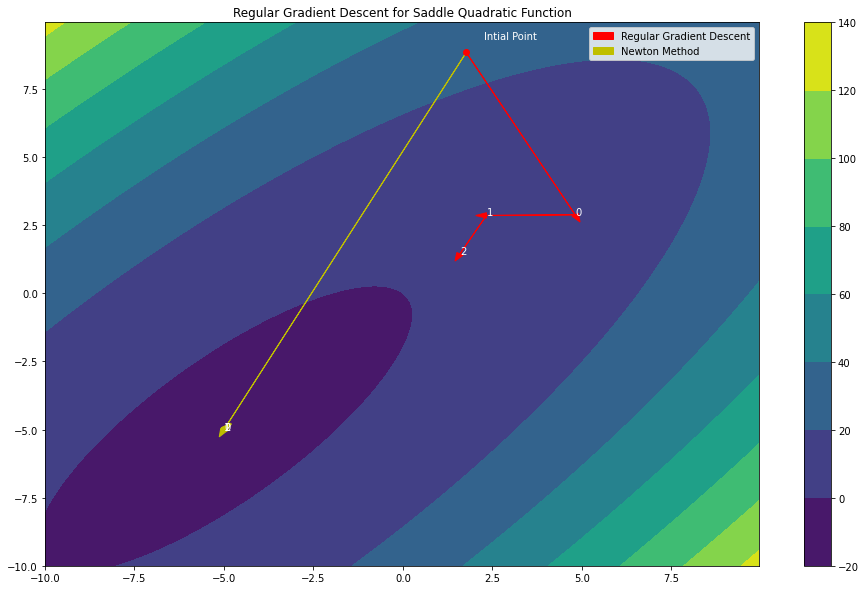

In [6]:
# Newton's Method
# Appropriately scaled the gradient information with the Hessian to rescale steps in different directions and obtain faster convergence
# Takes longer steps in the direction of lower gradient. Think Taylor series

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
patho = QuadFunc(a,a,-0.8*a,a,a)

steps = 3
lr = 1.0

newGD = Newtons(lr)
regGD = GradientDescent(lr,0,0)

func = patho

path1, _ = runOptim(init,regGD,func,steps)
path2, _ = runOptim(init,newGD,func,steps)

showPath(func,init,[path1,path2],['Regular Gradient Descent','Newton Method'],['r','y'],'Regular Gradient Descent for Saddle Quadratic Function')

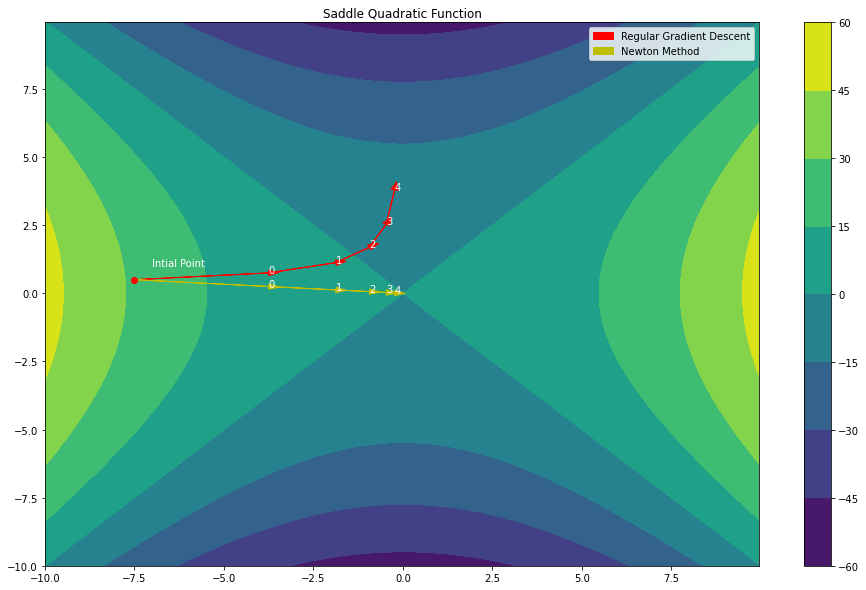

In [7]:
# Newton's method
# Unfortunately Newton's method is attrached to saddle points.
# Also there are practical issues with Hessian calculations.
# Moreover in DL, the loss surfaces are non-convex and this may result in extremely bad outcomes when using Newton's method.

saddle = QuadFunc(1.0,-1.0,0.0,0.0,0.0)
init = torch.tensor([-7.5,0.5])
steps = 5

regGD = GradientDescent(0.5,0,0)
newGD = Newtons(0.5)

func = saddle

path1, _ = runOptim(init,regGD,func,steps)
path2, _ = runOptim(init,newGD,func,steps)

showPath(func,init,[path1,path2],['Regular Gradient Descent','Newton Method'],['r','y'],'Saddle Quadratic Function')

#### RMSProp

$v_{t+1} = \gamma v_{t} + (1-\gamma) g_{t}^{2}$

$\Delta\theta_{t+1} = \frac{-\eta}{\sqrt{v_{t+1}}+\epsilon}g_{t}$

$\theta_{t+1} = \theta_{t} + \Delta\theta_{t+1}$



$\theta_{t}$ is the parameter at time-step $t$<br>
$\eta$ is the learning rate<br>
$g_{t}$ is the gradient at time-step $t$<br>
$v_{t}$ is the exponentially decaying average of squared gradients at time-step $t$<br>
$\epsilon$ is used to avoid division by zero

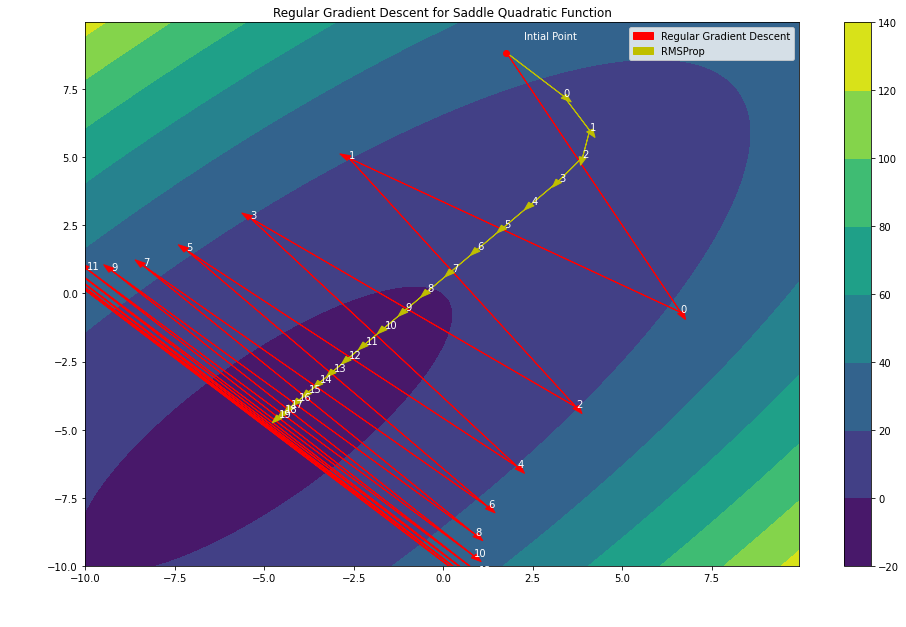

In [8]:
# RMSProp: Why can't we have different learning rate for each parameter? But which lr for which param?
# Dampens the osciallations and thereby avoid divergences and can therefore handle larger learning rates.
# Ability to provide larger updates to parameters associated with infrequently occuring features i.e features
# with mostly small gradients compared to other parameters.
# Check AdaDelta for another version and AdaGrad for a more primitive version

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
patho = QuadFunc(a,a,-0.8*a,a,a)

steps = 20
lr = 1.6

RMSPropGD = GradientDescent(lr,0,0.9)
regGD = GradientDescent(lr,0,0)

func = patho

path1, _ = runOptim(init,regGD,func,steps)
path2, _ = runOptim(init,RMSPropGD,func,steps)

showPath(func,init,[path1,path2],['Regular Gradient Descent','RMSProp'],['r','y'],'Regular Gradient Descent for Saddle Quadratic Function')

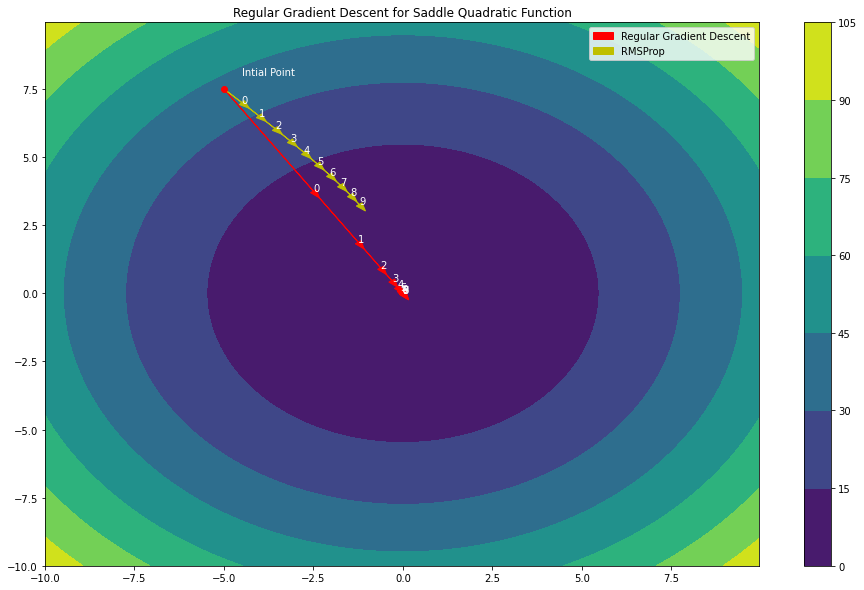

In [9]:
# RMSProp
# Can become very slow. Therefore when the parameter space is large i.e step size is smaller compared to the area
# to be explored, RMSProp can slow down greatly!

init = torch.tensor([-5.0,7.5])
simple = QuadFunc(1,1,0,0,0)
steps = 10

lr = 0.5

RMSPropGD = GradientDescent(lr,0,0.9)
regGD = GradientDescent(lr,0,0)

func = simple

path1, _ = runOptim(init,regGD,func,steps)
path2, _ = runOptim(init,RMSPropGD,func,steps)

showPath(func,init,[path1,path2],['Regular Gradient Descent','RMSProp'],['r','y'],'Regular Gradient Descent for Saddle Quadratic Function')

#### Momentum

$m_{t+1} = \gamma m_{t} + \eta g_{t}$

$\theta_{t+1} = \theta_{t} - m_{t+1}$

$\theta_{t}$ is the parameter at time-step $t$<br>
$\eta$ is the learning rate<br>
$g_{t}$ is the gradient at time-step $t$<br>
$m_{t}$ is the exponentially decaying average of gradients at time-step $t$<br>

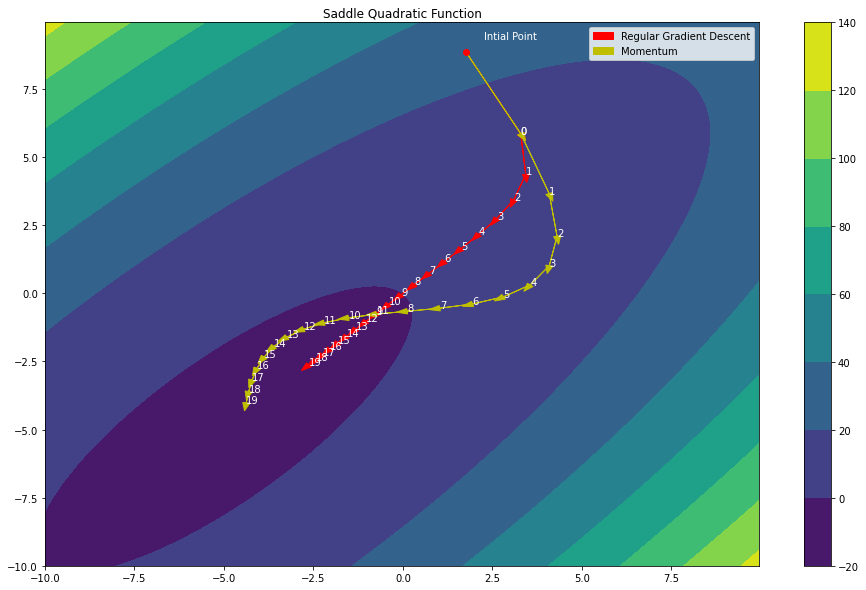

In [10]:
# Momentum = Awesome
# Momentum speeds things up in direction where gradient direction remains the same and slows things down in
# directions where oscillations occur. As a result it is also prone to oscillations when it speeds up way too much!

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
patho = QuadFunc(a,a,-0.8*a,a,a)

steps = 20
lr = 0.5

momGD = GradientDescent(lr,0.9,0)
regGD = GradientDescent(lr,0,0)

func = patho

path1, _ = runOptim(init,regGD,func,steps)
path2, _ = runOptim(init,momGD,func,steps)

showPath(func,init,[path1,path2],['Regular Gradient Descent','Momentum'],['r','y'],'Saddle Quadratic Function')

#### Nesterov's Accelerated Gradient

$g_{t} = \nabla f(\theta_{t}-\eta \gamma m_{t})$

$m_{t+1} = \gamma m_{t} + g_{t}$

$\theta_{t+1} = \theta_{t} - \eta m_{t+1}$

$\theta_{t}$ is the parameter at time-step $t$<br>
$\eta$ is the learning rate<br>
$g_{t}$ is the gradient at time-step $t$<br>
$m_{t}$ is the exponentially decaying average of gradients at time-step $t$<br>

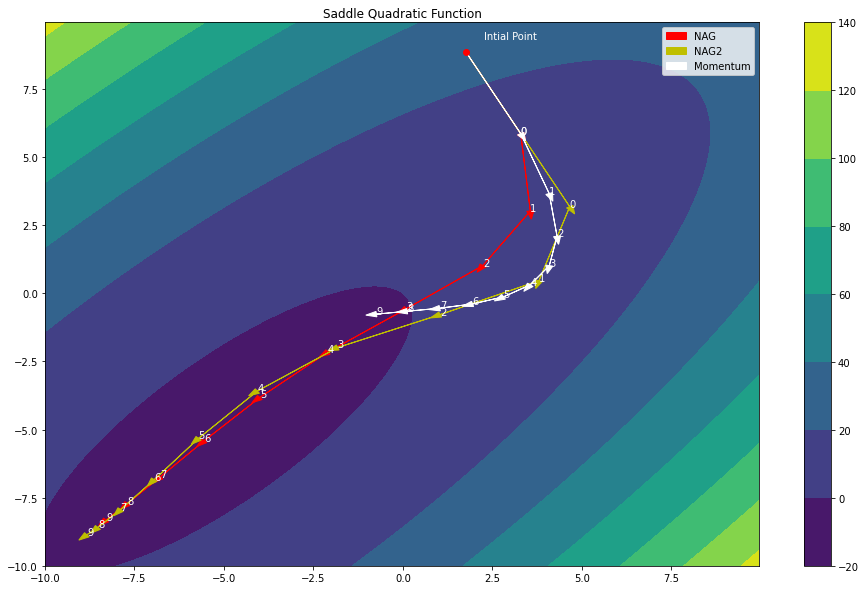

In [11]:
# NAG
# Smarter version of momentum
# Has an equivalent version which is a lot easier to implement

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
patho = QuadFunc(a,a,-0.8*a,a,a)

steps = 10
lr = 0.5
gamma = 0.9

momGD = GradientDescent(lr,gamma,0)
nagGD = NAG(lr,gamma)
nag2GD = NAG2(lr,gamma)

func = patho

path1, _ = runOptim(init,nagGD,func,steps,True)
path2, _ = runOptim(init,nag2GD,func,steps)
path3, _ = runOptim(init,momGD,func,steps)

showPath(func,init,[path1,path2,path3],['NAG','NAG2','Momentum'],['r','y','white'],'Saddle Quadratic Function')

#### Adam

$v_{t+1} = \gamma_{1} v_{t} + (1-\gamma_{1}) g_{t}^{2}$

$m_{t+1} = \gamma_{2} m_{t} + (1-\gamma_{2}) g_{t}$

$\hat{v}_{t+1} = \frac{v_{t+1}}{1-\gamma_{1}^{t+1}}$

$\hat{m}_{t+1} = \frac{m_{t+1}}{1-\gamma_{2}^{t+1}}$

$\Delta\theta_{t+1} = \frac{-\eta}{\sqrt{\hat{v}_{t+1}}+\epsilon}\hat{m}_{t+1}$

$\theta_{t+1} = \theta_{t} + \Delta\theta_{t+1}$



$\theta_{t}$ is the parameter at time-step $t$<br>
$\eta$ is the learning rate<br>
$g_{t}$ is the gradient at time-step $t$<br>
$v_{t}$ is the exponentially decaying average of squared gradients at time-step $t$<br>
$m_{t}$ is the exponentially decaying average of gradients at time-step $t$<br>
$\epsilon$ is used to avoid division by zero

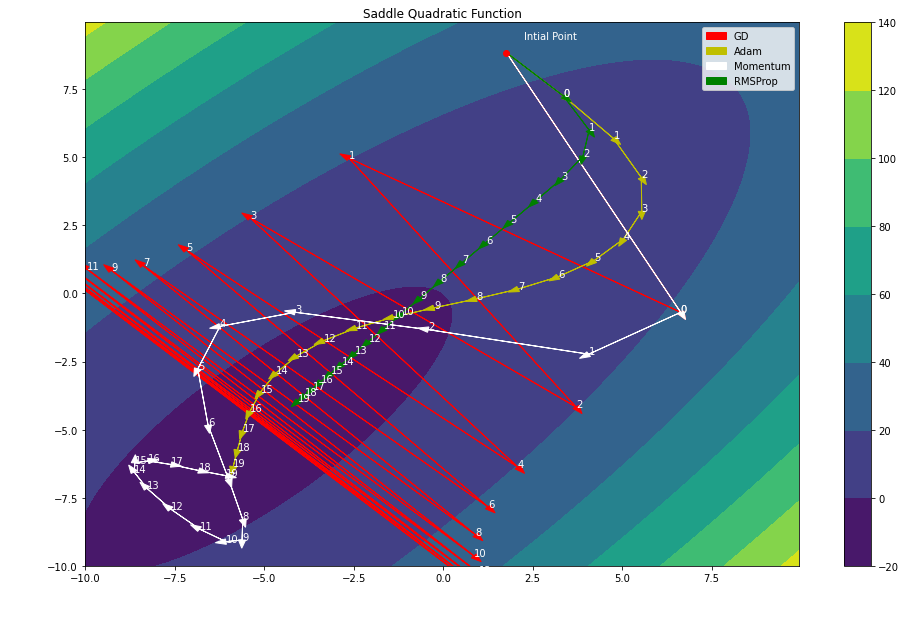

In [12]:
# Adam: Best of all worlds?

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
patho = QuadFunc(a,a,-0.8*a,a,a)

steps = 20
lr = 1.6

adamGD = GradientDescent(lr,0.9,0.999)
regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
rmsGD = GradientDescent(lr,0,0.999)

func = patho

path1, _ = runOptim(init,regGD,func,steps)
path2, _ = runOptim(init,adamGD,func,steps)
path3, _ = runOptim(init,momGD,func,steps)
path4, _ = runOptim(init,rmsGD,func,steps)

showPath(func,init,[path1,path2,path3,path4],['GD','Adam','Momentum','RMSProp'],['r','y','w','g'],'Saddle Quadratic Function')

### Realworld Optimizers

https://pytorch.org/docs/stable/optim.html

### Which optimizer should I use?

<u>Helpful Heuristics (NOT RULES):</u>

1. Sparse features/data -> Adaptive learning-rate methods
2. Faster convergence -> Adaptive learning-rate methods
3. Better minima -> SGD + momentum

### Initialization of Neural Networks

#### Why is initialization important

1. Resolves the issue of exploding/vanishing gradients/activations (to some extent)
1. Faster convergence
1. Helps reach better minima

#### QUESTION: Initialize the network with 0? With a contant value?

#### Short Proof for Kaiming Initialization 

<b>Forward Pass</b>

$y_{l} = W_{l} x_{l} + b_{l}$

$x_{l+1} = Relu(y_{l})$

<b>Assumptions:</b><br>

1. $W_{l}$ is $n_{l+1} \times n_{l}$ matrix with all it's elements being iid and each distribution symmetric around the mean with $E[W_{l}] = 0$
1. $x_{l}$ is $n_{l} \times 1$ vector with all elements being iid
1. $x_{l}$ and $W_{l}$ are mutually independent (element-wise)

$Var[y_{_,l}] = n_{l} Var[w_{_,l} x_{_,l} ]$<br>
$Var[y_{_,l}] = n_{l} Var[w_{_,l}] E[x_{_,l}^2]$<br>
$Var[y_{_,l}] = \frac{1}{2} n_{l} Var[w_{_,l}] Var[y_{_,l-1}]$<br>

And behold....<br>
$Var[y_{_,L}] = Var[y_{_,1}] \prod_{i}\frac{1}{2} n_{i} Var[w_{_,i}] $

Kaiming's idea:<br>
Initialize the weights such that $\frac{1}{2}n_{i} Var[w_{_,i}] = 1$
Terefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i}}}$

<b>Backward Pass</b>

$\Delta x_{l} = W_{l}^T \Delta y_{l}$

$\Delta y_{l} = Relu^{'}(y_{l}) \Delta x_{l+1}$ 

<b>Assumptions:</b><br>

1. $\Delta y_{l}$ is $n_{l+1} \times 1$ vector with all elements being iid
1. $\Delta y_{l}$ and $W_{l}$ are mutually independent (element-wise)
1. $\Delta x_{l+1}$ and $Relu^{'}(y_{l})$ are mutually independent

$Var[\Delta x_{_,l}] = n_{l+1} Var[w_{_,l}^T \Delta y_{_,l}]$<br>
$Var[\Delta x_{_,l}] = n_{l+1} Var[w_{_,l}^T] Var[\Delta y_{_,l}]$<br>
$Var[\Delta x_{_,l}] = \frac{1}{2} n_{l+1} Var[w_{_,l}^T] Var[\Delta x_{_,l+1}]$<br>

Finally: <br>
$Var[\Delta x_{_,2}] = Var[\Delta x_{_,L+1}] \prod_{i=2}^L\frac{1}{2} n_{i+1} Var[w_{_,i}^T]$

Kaiming's idea:<br>
Initialize the weights such that $\frac{1}{2}n_{i+1} Var[w_{i}^T] = 1$<br>
Terefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i+1}}}$

<b>Xavier's Initialization</b><br>
Similar to Kaiming but did not consider the Relu activation and by default assumed a linear activation. Therefore the factor $\frac{1}{2}$ that we see in the Kaiming's initialization is not present in Xavier. He takes a harmonic mean of the two results for initialization.

Terefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i+1}+n_{i}}}$

<b>Kaiming's Initialization</b>
Use either of the forward-based initialization or the backward-based initialization. The difference isn't much!


#### That's all great....but show me the real world results

<b>Activation values with standard initialization</b>
<img src='images/activation_std.png'><br>
source: <a href='http://proceedings.mlr.press/v9/glorot10a.html'> Xavier's Paper </a>

<b>Gradient values with standard initialization</b>
<img src='images/back_prop_grad_std.png'>
source: <a href='http://proceedings.mlr.press/v9/glorot10a.html'> Xavier's Paper </a>

<b>Activation values with Xavier's initialization</b>
<img src='images/activation_norm.png'><br>
source: <a href='http://proceedings.mlr.press/v9/glorot10a.html'> Xavier's Paper </a>

<b>Gradient values with Xavier's initialization</b>
<img src='images/back_prop_grad_norm.png'>
source: <a href='http://proceedings.mlr.press/v9/glorot10a.html'> Xavier's Paper </a>

<b>Error rate as a function of epochs with Xavier vs Kaiming initialization, 22-layer modelon</b>
<img src='images/converge_22layers.png'><br>
source: <a href='https://arxiv.org/abs/1502.01852'> Kaiming's Paper </a>

<b>Error rate as a function of epochs with Xavier vs Kaiming initialization, 30-layer model</b>
<img src='images/converge_30layers.png'>
source: <a href='https://arxiv.org/abs/1502.01852'> Kaiming's Paper </a>

### References

https://pouannes.github.io/blog/initialization/ <br>
https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentvariants